In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

/Users/pankajkishore/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/pankajkishore/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:

from keras import backend as K
import os
from importlib import reload

def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend



In [6]:
np.random.seed(7)

In [5]:
#load the dataset
msft_dataset = pd.read_csv("hack.csv")
msft_dataset.head()

,date,close,volume,open,high,low
0,1/26/2017,136.660004,22255600,137.339996,137.500000,136.419998
1,1/27/2017,136.190002,19467800,136.770004,137.039993,135.649994
2,1/30/2017,134.289993,40464400,135.229996,135.240005,133.240005
3,1/31/2017,135.229996,32945000,133.869995,135.559998,133.479996
4,2/1/2017,135.149994,30010500,136.220001,136.869995,134.699997


In [6]:
msft_dataset.dtypes


date       object
close     float64
volume      int64
open      float64
high      float64
low       float64
dtype: object

In [7]:
msft_dataset['date'] = pd.to_datetime(msft_dataset['date'])
msft_dataset['close'] = pd.to_numeric(msft_dataset['close'], downcast='float')

In [8]:
msft_dataset.set_index('date',inplace=True)
msft_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2017-01-26 to 2019-01-25
Data columns (total 5 columns):
close     503 non-null float32
volume    503 non-null int64
open      503 non-null float64
high      503 non-null float64
low       503 non-null float64
dtypes: float32(1), float64(3), int64(1)
memory usage: 21.6 KB


In [9]:
msft_dataset.sort_index(inplace=True)


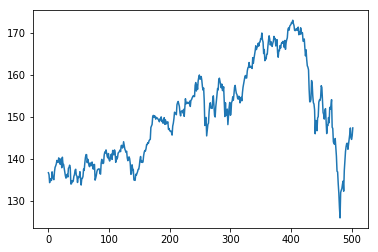

In [10]:

#extract just close prices as that is what we want to predict
msft_close = msft_dataset['close']
msft_close = msft_close.values.reshape(len(msft_close), 1)
plt.plot(msft_close)
plt.show()

In [11]:
#normalize data
scaler = MinMaxScaler(feature_range=(0,1))

In [12]:
msft_close = scaler.fit_transform(msft_close)
msft_close

array([[0.22868061],
       [0.21871018],
       [0.17840457],
       [0.19834518],
       [0.19664812],
       [0.18943572],
       [0.23313522],
       [0.21128535],
       [0.19855762],
       [0.19346619],
       [0.23377156],
       [0.25583363],
       [0.26347065],
       [0.2732284 ],
       [0.29083562],
       [0.2825625 ],
       [0.28065324],
       [0.3037758 ],
       [0.29062366],
       [0.27301645],
       [0.270895  ],
       [0.29953337],
       [0.25371218],
       [0.30717015],
       [0.27301645],
       [0.270895  ],
       [0.25074244],
       [0.23165035],
       [0.21255827],
       [0.20110297],
       [0.21383119],
       [0.22061944],
       [0.20683074],
       [0.25137877],
       [0.2551973 ],
       [0.26686478],
       [0.25413656],
       [0.17161655],
       [0.1722529 ],
       [0.18879938],
       [0.18264747],
       [0.18795085],
       [0.21022463],
       [0.21955872],
       [0.24140835],
       [0.24607539],
       [0.21531606],
       [0.211

In [13]:
#split data into train and test
train_size = int(len(msft_close)* 0.8)
test_size = len(msft_close) - train_size

msft_train, msft_test = msft_close[0:train_size, :], msft_close[train_size:len(msft_close), :]

print('Split data into train and test: ', len(msft_train), len(msft_test))

Split data into train and test:  402 101


In [14]:
#need to now convert the data into time series looking back over a period of days...e.g. use last 7 days to predict price

def create_ts(ds, series):
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)

series = 3

trainX, trainY = create_ts(msft_train, series)
testX, testY = create_ts(msft_test, series)

In [15]:
trainX


array([[0.22868061, 0.21871018, 0.17840457],
       [0.21871018, 0.17840457, 0.19834518],
       [0.17840457, 0.19834518, 0.19664812],
       ...,
       [0.95205736, 0.96096706, 0.94993615],
       [0.96096706, 0.94993615, 0.9696646 ],
       [0.94993615, 0.9696646 , 0.97496796]], dtype=float32)

In [16]:
trainX[0]


array([0.22868061, 0.21871018, 0.17840457], dtype=float32)

In [17]:
testX.shape[1]

3

In [18]:

#reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


In [19]:

#build the model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
#fit the model
model.fit(trainX, trainY, epochs=100, batch_size=32)

Epoch 1/100
398/398 [==============================] - 2s 5ms/step - loss: 0.2311
Epoch 2/100
398/398 [==============================] - 0s 288us/step - loss: 0.1930
Epoch 3/100
398/398 [==============================] - 0s 291us/step - loss: 0.1574
Epoch 4/100
398/398 [==============================] - 0s 286us/step - loss: 0.1267
Epoch 5/100
398/398 [==============================] - 0s 278us/step - loss: 0.1000
Epoch 6/100
398/398 [==============================] - 0s 308us/step - loss: 0.0768
Epoch 7/100
398/398 [==============================] - 0s 313us/step - loss: 0.0590
Epoch 8/100
398/398 [==============================] - 0s 303us/step - loss: 0.0448
Epoch 9/100
398/398 [==============================] - 0s 301us/step - loss: 0.0342
Epoch 10/100
398/398 [==============================] - 0s 323us/step - loss: 0.0268
Epoch 11/100
398/398 [==============================] - 0s 348us/step - loss: 0.0220
Epoch 12/100
398/398 [==============================] - 0s 307us/step - loss

398/398 [==============================] - 0s 336us/step - loss: 9.3439e-04
Epoch 96/100
398/398 [==============================] - 0s 304us/step - loss: 9.3156e-04
Epoch 97/100
398/398 [==============================] - 0s 332us/step - loss: 9.3279e-04
Epoch 98/100
398/398 [==============================] - 0s 338us/step - loss: 9.3423e-04
Epoch 99/100
398/398 [==============================] - 0s 347us/step - loss: 9.3444e-04
Epoch 100/100
398/398 [==============================] - 0s 326us/step - loss: 9.3263e-04


In [20]:
#test this model out
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)
#unscale predictions
trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [21]:
#lets calculate the root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)

Train score: %.2f rmse 1.4380383771221272
Test score: %.2f rmse 2.820703908668582


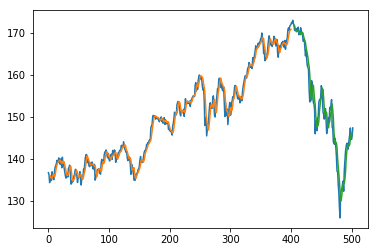

In [22]:

#lets plot the predictions on a graph and see how well it did
train_plot = np.empty_like(msft_close)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(msft_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(msft_close)-1, :] = testPredictions

#plot on graph
plt.plot(scaler.inverse_transform(msft_close))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()

In [26]:
twitterdata = pd.read_csv('twitter_tweets_hackathon.csv',sep='\t',encoding='utf-8')



twitterdata

,Unnamed: 0,text
0,0,iShares Russell 1000 ETF (IWB) Shares Bought b...
1,1,"Donald L. Hagan LLC Sells 7,820 Shares of iSha..."
2,2,iShares Russell Mid-Cap ETF (IWR) Shares Bough...
3,3,"Eukles Asset Management Buys Shares of 8,529 i..."
4,4,iShares Russell 2000 ETF (IWM) Shares Bought b...
5,5,iShares Russell 2000 Growth ETF $IWO Stake Red...
6,6,iShares Russell 3000 Value Index (IUSV) Holdin...
7,7,Landsberg Bennett &amp; Dubbaneh LLC Buys New ...
8,8,"2,834 Shares in iShares Russell 2000 ETF (IWM)..."
9,9,Reinhart Partners Inc. Takes Position in iShar...


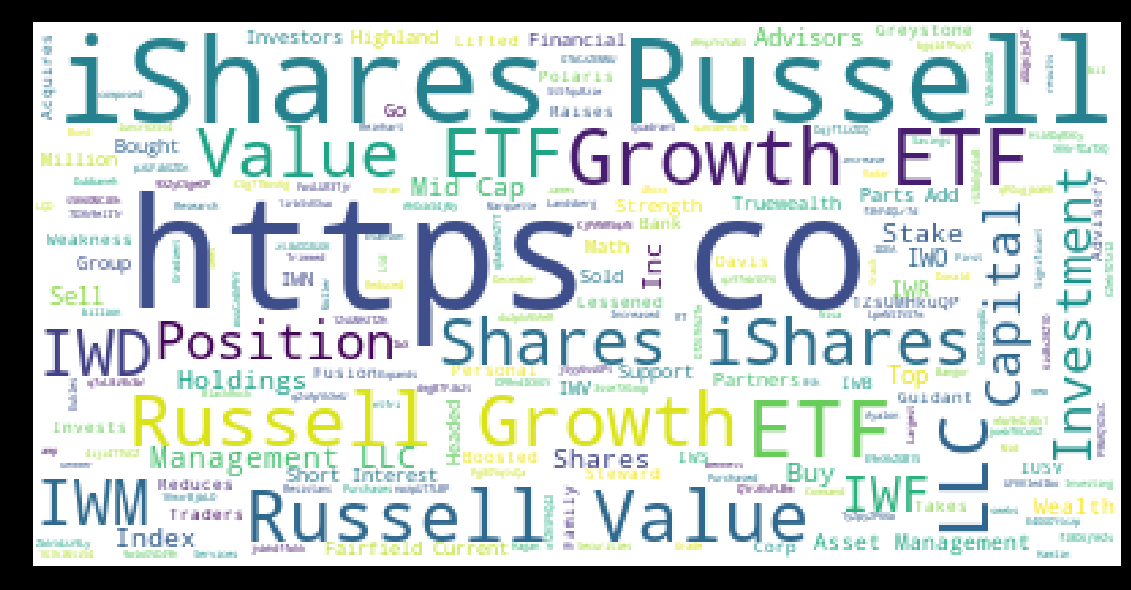

In [27]:
##########Extra############
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
def wordcloud(twitterdata,col):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2018).generate(" ".join([i for i in twitterdata[col]]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Hackathon")
wordcloud(twitterdata,'text')

In [28]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    return score['compound']


score_dic = []

for i in twitterdata['text']:
    counter = 0
    score = 0
    counter += 1
    score += sentiment_analyzer_scores(i)
    score_dic.append(score)
    
    

twitterdata['sentiment'] = score_dic
df_temp = twitterdata
df_temp=df_temp.sort_values(by=['sentiment'], ascending=False)
df_temp
twitterdata=df_temp

twitterdata

,Unnamed: 0,text,sentiment
50,50,iShares Russell 1000 Value Index $IWD Sees Sig...,0.8176
15,15,Fusion Family Wealth LLC Acquires 232 Shares o...,0.7906
26,26,We Did The Math And The iShares Russell Top 20...,0.7783
10,10,Investors Sell Shares of iShares Russell 1000 ...,0.7783
46,46,iShares Russell 1000 Growth Index (IWF) Shares...,0.7430
3,3,"Eukles Asset Management Buys Shares of 8,529 i...",0.7269
27,27,Short Interest in iShares Russell 1000 Value E...,0.7003
11,11,Traders Sell iShares Russell 1000 Value ETF $I...,0.6808
29,29,"Fusion Family Wealth LLC Takes $33,000 Positio...",0.6808
30,30,"Guidant Wealth Advisors Invests $278,000 in iS...",0.6808


In [33]:
twitterdata.reset_index(drop=True, inplace=True)
twitterdata

,Unnamed: 0,text,sentiment
0,50,iShares Russell 1000 Value Index $IWD Sees Sig...,0.8176
1,15,Fusion Family Wealth LLC Acquires 232 Shares o...,0.7906
2,26,We Did The Math And The iShares Russell Top 20...,0.7783
3,10,Investors Sell Shares of iShares Russell 1000 ...,0.7783
4,46,iShares Russell 1000 Growth Index (IWF) Shares...,0.7430
5,3,"Eukles Asset Management Buys Shares of 8,529 i...",0.7269
6,27,Short Interest in iShares Russell 1000 Value E...,0.7003
7,11,Traders Sell iShares Russell 1000 Value ETF $I...,0.6808
8,29,"Fusion Family Wealth LLC Takes $33,000 Positio...",0.6808
9,30,"Guidant Wealth Advisors Invests $278,000 in iS...",0.6808


In [45]:
mylist = twitterdata['sentiment'].tolist()
mylist

[0.8176,
 0.7906,
 0.7783,
 0.7783,
 0.743,
 0.7269,
 0.7003,
 0.6808,
 0.6808,
 0.6808,
 0.6597,
 0.6597,
 0.6597,
 0.6369,
 0.5859,
 0.5719,
 0.5574,
 0.5574,
 0.5574,
 0.5423,
 0.5267,
 0.5267,
 0.5267,
 0.4939,
 0.4019,
 0.4019,
 0.4019,
 0.3818,
 0.3818,
 0.3818,
 0.3818,
 0.3818,
 0.3818,
 0.3818,
 0.3818,
 0.3818,
 0.3612,
 0.3612,
 0.3612,
 0.34,
 0.34,
 0.34,
 0.34,
 0.34,
 0.296,
 0.296,
 0.296,
 0.296,
 0.296,
 0.25,
 0.25,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [46]:
mylist.extend([0 for i in range(447)])

In [47]:
print(len(mylist))

503


In [48]:
msft_dataset['sentiment']= mylist

In [49]:
msft_dataset

,close,volume,open,high,low,sentiment
date,,,,,,
2017-01-26,136.660004,22255600,137.339996,137.500000,136.419998,0.8176
2017-01-27,136.190002,19467800,136.770004,137.039993,135.649994,0.7906
2017-01-30,134.289993,40464400,135.229996,135.240005,133.240005,0.7783
2017-01-31,135.229996,32945000,133.869995,135.559998,133.479996,0.7783
2017-02-01,135.149994,30010500,136.220001,136.869995,134.699997,0.7430
2017-02-02,134.809998,19935700,135.300003,135.669998,134.490005,0.7269
2017-02-03,136.869995,24534100,135.990005,136.979996,135.509995,0.7003
2017-02-06,135.839996,23691500,136.399994,136.779999,135.429993,0.6808
2017-02-07,135.240005,30342200,135.820007,136.470001,134.770004,0.6808


In [50]:
#split data into train and test
train_size = int(len(msft_close)* 0.8)
test_size = len(msft_close) - train_size

msft_train, msft_test = msft_close[0:train_size, :], msft_close[train_size:len(msft_close), :]

print('Split data into train and test: ', len(msft_train), len(msft_test))

Split data into train and test:  402 101


In [51]:
series = 3

trainX, trainY = create_ts(msft_train, series)
testX, testY = create_ts(msft_test, series)

Epoch 1/100
398/398 [==============================] - 2s 5ms/step - loss: 0.1842
Epoch 2/100
398/398 [==============================] - 0s 328us/step - loss: 0.1443
Epoch 3/100
398/398 [==============================] - 0s 288us/step - loss: 0.1090
Epoch 4/100
398/398 [==============================] - 0s 316us/step - loss: 0.0792
Epoch 5/100
398/398 [==============================] - 0s 316us/step - loss: 0.0559
Epoch 6/100
398/398 [==============================] - 0s 320us/step - loss: 0.0378
Epoch 7/100
398/398 [==============================] - 0s 314us/step - loss: 0.0257
Epoch 8/100
398/398 [==============================] - 0s 311us/step - loss: 0.0181
Epoch 9/100
398/398 [==============================] - 0s 312us/step - loss: 0.0138
Epoch 10/100
398/398 [==============================] - 0s 339us/step - loss: 0.0117
Epoch 11/100
398/398 [==============================] - 0s 337us/step - loss: 0.0105
Epoch 12/100
398/398 [==============================] - 0s 300us/step - loss

398/398 [==============================] - 0s 377us/step - loss: 9.3291e-04
Epoch 96/100
398/398 [==============================] - 0s 391us/step - loss: 9.3242e-04
Epoch 97/100
398/398 [==============================] - 0s 397us/step - loss: 9.3240e-04
Epoch 98/100
398/398 [==============================] - 0s 379us/step - loss: 9.3123e-04
Epoch 99/100
398/398 [==============================] - 0s 381us/step - loss: 9.3714e-04
Epoch 100/100
398/398 [==============================] - 0s 331us/step - loss: 9.3108e-04
Train score: %.2f rmse 1.4379297979271732
Test score: %.2f rmse 2.7774858173914003


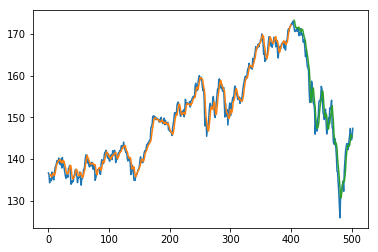

In [52]:

#reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


#build the model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
#fit the model
model.fit(trainX, trainY, epochs=100, batch_size=32)


#test this model out
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)
#unscale predictions
trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])


#lets calculate the root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)




#lets plot the predictions on a graph and see how well it did
train_plot = np.empty_like(msft_close)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(msft_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(msft_close)-1, :] = testPredictions

#plot on graph
plt.plot(scaler.inverse_transform(msft_close))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()